#Tosi et al Benchmark

This notebook generates models from the <a name="ref-1"/>[(Tosi et al., 2015)](#cite-tosi2015community) Benchmark in Underworld2. The Underworld results are compared to the benchmark model run on Fenics. Input files for the Fenics models were provided by Petra Maierova. The comparison of Underworld2 and Fenics is useful because both are FEM codes which can be built Python environment and both interface to PetSc to solve the linear systems. 

In [1]:
#%%javascript
#IPython.load_extensions('calico-document-tools');

In [2]:
# =============================================================================
# CONSTANTS and PARAMETERS
# =============================================================================
RA  = 1e2        # Rayleigh number
TS  = 0          # surface temperature
TB  = 1          # bottom boundary temperature (melting point)
CASE = 4 # select identifier of the testing case (1-5)
YSTRESS = 1.0    # yield stress=1 in cases 1-4, =3.0..5.0 in case 5
ETA_T = 1e5
ETA_Y = 10
ETA0 = 1e-3
TMAX = 3.0
IMAX = 1000
XDIV, YDIV = 80, 80 # number of horizontal and vertical divisions
C_CFL = 0.5      # Courant number
#dt = Constant(1e-10)# initial value of time step

In [3]:
# RT PIC - classic and nearest neighbour
import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt
import numpy as np
import os

In [4]:
dim = 2

# create mesh objects
elementMesh = uw.mesh.FeMesh_Cartesian( elementType=("linear","constant"), 
                                         elementRes=(XDIV,YDIV), 
                                           minCoord=(0.,0.), 
                                           maxCoord=(1.,1.)  )
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh 

In [5]:
# create fevariables
velocityField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=dim )
pressureField    = uw.fevariable.FeVariable( feMesh=constantMesh, nodeDofCount=1 )
temperatureField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1 )

In [6]:
# create some dummy fevariables for doing top and bottom boundary integrations
topField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1)
bottomField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1)

topField.data[:] = 0.
bottomField.data[:] = 0.

# Set top / bottom boundaries to 1
for index in linearMesh.specialSets["MinJ_VertexSet"]:
    bottomField.data[index] = 1.
for index in linearMesh.specialSets["MaxJ_VertexSet"]:
    topField.data[index] = 1.

#ICs and BCs

In [7]:
# Initialise data.. Note that we are also setting boundary conditions here
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
temperatureField.data[:] = 0.

# Setup temperature initial condition via numpy arrays
A = 0.01
import math
#Note that width = height = 1
tempNump = temperatureField.data
for index, coord in enumerate(linearMesh.data):
    pertCoeff = (1- coord[1]) + A*math.cos( math.pi * coord[0] ) * math.sin( math.pi * coord[1] )
    tempNump[index] = pertCoeff;
    

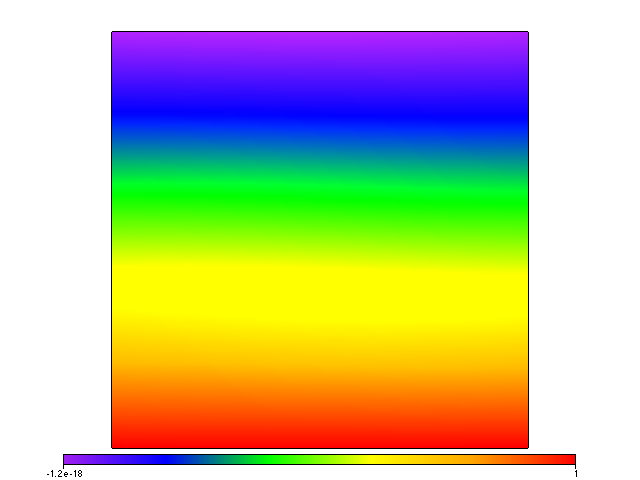

In [8]:
figtemp = plt.Figure()
figtemp.Surface(temperatureField, elementMesh)
figtemp.show()

In [9]:
# Get list of special sets.
# These are sets of vertices on the mesh. In this case we want to set them as boundary conditions.
linearMesh.specialSets.keys()

['AllWalls',
 'MaxI_VertexSet',
 'MinJ_VertexSet',
 'MinI_VertexSet',
 'MaxJ_VertexSet']

    freeSlipBC = uw.conditions.DirichletCondition(velocityField, (IWalls,JWalls) )  # this will give free slip sides
    noSlipBC = uw.conditions.DirichletCondition(velocityField, (IWalls+JWalls,IWalls+JWalls) )  

In [10]:
# Get the actual sets 
#
#  HJJJJJJH
#  I      I
#  I      I
#  I      I
#  HJJJJJJH
#  
#  Note that H = I & J 

# Note that we use operator overloading to combine sets
IWalls = linearMesh.specialSets["MinI_VertexSet"] + linearMesh.specialSets["MaxI_VertexSet"]
JWalls = linearMesh.specialSets["MinJ_VertexSet"] + linearMesh.specialSets["MaxJ_VertexSet"]

In [11]:
# Now setup the dirichlet boundary condition
# Note that through this object, we are flagging to the system 
# that these nodes are to be considered as boundary conditions. 
# Also note that we provide a tuple of sets.. One for the Vx, one for Vy.
freeslipBC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                              nodeIndexSets=(IWalls,JWalls) )

# also set dirichlet for temp field
tempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              nodeIndexSets=(JWalls,) )

In [12]:
# Set temp boundaries 
# on the boundaries
for index in linearMesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = TB
for index in linearMesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = TS

#Viscosity




In [13]:
#Make some necessary arrays for the the 

secinvCopy = fn.tensor.second_invariant( 
                    fn.tensor.symmetric( 
                        velocityField.gradientFn ))

coordinate = fn.input()

In [14]:
ETA_Y

10

In [15]:
#Remember to use floats everywhere when setting up functions

#Linear viscosities
viscosityl1 = fn.math.exp(math.log(ETA_T)*-1*temperatureField)

viscosityl2 = fn.math.exp((math.log(ETA_T)*-1*temperatureField) + (1.-coordinate[1])*math.log(ETA_Y))

viscosityFn1 = viscosityl1 #This one always gets passed to the first velcotity solve

#Von Mises effective viscosity
viscosityp = ETA0 + YSTRESS/(secinvCopy/math.sqrt(0.5)) #extra factor to account for underworld second invariant form


if CASE == 1:
    viscosityFn2 = viscosityFn1
elif CASE == 2:
    viscosityFn2 = 2./(1./viscosityl1 + 1./viscosityp)
elif CASE == 3:
    viscosityFn2 = viscosityl2
else:
    viscosityFn2 = 2./(1./viscosityl2 + 1./viscosityp)


In [16]:
math.exp(1.)

2.718281828459045

In [17]:
math.log(ETA_Y)

2.302585092994046

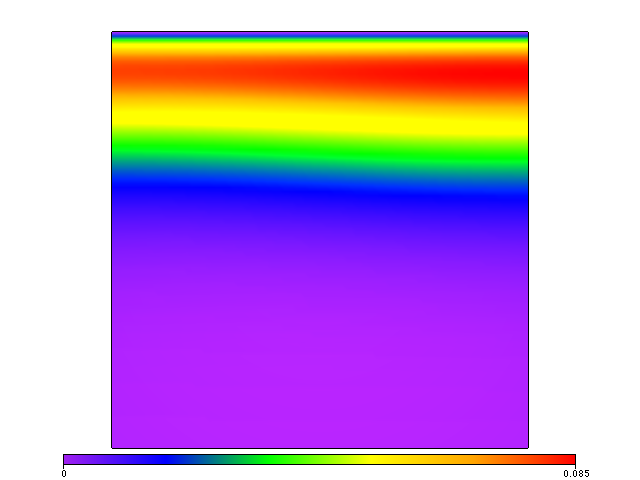

In [18]:
# lets take a look at the eta function
figEta = plt.Figure()
figEta.Surface(viscosityl2 - viscosityl1, linearMesh)
figEta.show()

In [19]:
densityFn = RA*temperatureField
# Define our gravity using a python tuple (this will be automatically converted to a function)
gravity = ( 0.0, 1.0 )
# now create a buoyancy force vector.. the gravity tuple is converted to a function 
# here via operator overloading
buoyancyFn = gravity*densityFn

##Build the Stokes system, solvers, advection-diffusion

In [20]:
#We first set up a linear Stokes system to get the initial velocity
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              viscosityFn=fn.exception.SafeMaths(viscosityFn1), 
                              bodyForceFn=buoyancyFn)

In [21]:
#Solve for initial velocity field - so we can begin the non-linear part
stokesPIC.solve()

In [22]:
# Setup the Stokes system again, now with linear or nonlinear visocity viscosity.
stokesPIC2 = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              viscosityFn=fn.exception.SafeMaths(viscosityFn2), 
                              bodyForceFn=buoyancyFn )

In [23]:
solver = uw.systems.Solver(stokesPIC2)

In [24]:
# Create advdiff system
advDiff = uw.systems.AdvectionDiffusion( temperatureField, velocityField, diffusivity=1., conditions=[tempBC,] )
# Also create some integral objects which are used to calculate statistics.
v2sum_integral  = uw.utils.Integral( feMesh=linearMesh, fn=fn.math.dot(velocityField, velocityField) ) 
volume_integral = uw.utils.Integral( feMesh=linearMesh, fn=1. )

##Metrics for benchmark

For cases 1-4, participants were asked to report a number of diagnostic quantities to be measured after reaching steady state:

* Average temp... $$  \langle T \rangle  = \int^1_0 \int^1_0 T \, dxdy $$
* Top and bottom Nusselt numbers... $$N = \int^1_0 \frac{\partial T}{\partial y} \rvert_{y=0/1} \, dx$$
* RMS velocity over the whole domain, surface and max velocity at surface
* max and min viscosity over the whole domain
* average rate of work done against gravity...$$\langle W \rangle = \int^1_0 \int^1_0 T u_y \, dx dy$$
* and the average rate of viscous dissipation...$$\langle \Phi \rangle = \int^1_0 \int^1_0 \tau_{ij} \dot \epsilon_{ij} \, dx dy$$

* In steady state, if thermal energy is accurately conserved, the difference between $\langle W \rangle$ and $\langle \Phi \rangle / Ra$ must vanish, so also reported is the percentage error: 

$$ \delta = \frac{\lvert \langle W \rangle - \frac{\langle \Phi \rangle}{Ra} \rvert}{max \left(  \langle W \rangle,  \frac{\langle \Phi \rangle}{Ra}\right)} \times 100% $$

In [25]:
def avg_temp():
    temp = uw.utils.Integral(temperatureField, linearMesh)
    return temp.integrate()[0]

def nuss():
    nt = []
    nb = []
    grad = temperatureField.gradientFn 
    gradarray = grad.evaluate(linearMesh)
    for index in linearMesh.specialSets["MaxJ_VertexSet"]:
        nt.append(gradarray[index][1]*(1./XDIV))
    for index in linearMesh.specialSets["MinJ_VertexSet"]:
        nb.append(gradarray[index][1]*(1./XDIV))
    n1 = sum(nt)
    n0 = sum(nb)
    return abs(n1), abs(n0)
    
def rms():
    squared = uw.utils.Integral(fn.math.dot(velocityField,velocityField), linearMesh)
    area = uw.utils.Integral(1.,linearMesh)
    return math.sqrt(squared.integrate()[0]/area.integrate()[0])

def rms_surf():
    xvelocityField = fn.math.dot(velocityField,np.array([1.,0.]))
    squared = uw.utils.Integral(fn.math.dot(topField, fn.math.dot(xvelocityField,xvelocityField)), linearMesh)
    toparea = uw.utils.Integral((topField*1.),linearMesh)
    return math.sqrt(squared.integrate()[0]/toparea.integrate()[0])

def max_vx_surf():
    surf_vels =[]
    for index in linearMesh.specialSets["MaxJ_VertexSet"]:
        surf_vels.append(velocityField.data[index][0])
    return max(surf_vels)

def gravwork():
    dw = uw.utils.Integral(temperatureField*velocityField[1], linearMesh)
    return dw.integrate()[0]

#note that viscosityFn2 is used here, so this is not case independent. 
def viscdis():
    secinv = fn.tensor.second_invariant( 
                    fn.tensor.symmetric( 
                        velocityField.gradientFn ))
    sinner = fn.math.dot(secinv,secinv)
    vd = uw.utils.Integral((4.*viscosityFn2*sinner), linearMesh)
    return vd.integrate()[0]

def visc_extr():
    testfn = fn.view.min_max(viscosityFn2)
    #evaluate on the mesh
    testfn.evaluate(linearMesh) 
    vmax, vmin = testfn.max_global(), testfn.min_global()
    return vmax, vmin
    
        

#linearMesh.specialSets["MinJ_VertexSet"]()

In [26]:
linearMesh.maxCoord[1]

1.0

In [27]:
testfn = fn.view.min_max(viscosityFn2)
#evaluate on the mesh
testfn.evaluate(linearMesh) 
testfn.max_global()

1.9534210664608385

In [28]:
test = fn.math.dot(velocityField,velocityField)
type(test)

underworld.function.math.dot

In [29]:
surf_vels =[]
for index in linearMesh.specialSets["MaxJ_VertexSet"]:
    surf_vels.append(velocityField.data[index][0])
max(surf_vels)

0.12932630526971611

##solve using internal Picard iteration

In [30]:
# Stepping. Initialise time and timestep.
import time
realtime = 0.
step = 0
timevals = [0.]
vrmsvals = []

In [31]:
import matplotlib.pylab as plt

In [33]:
start = time.clock()
fname = "uw_results_case" + str(CASE) + ".dat"
f_o = open(os.path.join("./",fname), 'w')
# Perform steps
#while timevals[step]< 0.1:
while step < 1000:
    #Enter non-linear loop
    solver.solve(nonLinearIterate=True)
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advDiff.integrate(dt)
    # Increment
    realtime += dt
    step += 1
    timevals.append(realtime)
    # Calculate the Metrics
    Avg_temp = avg_temp()
    Rms = rms()
    Rms_surf = rms_surf()
    Max_vx_surf = max_vx_surf()
    Gravwork = gravwork()
    Viscdis = viscdis()
    nu1, nu0 = nuss()
    etamax, etamin = visc_extr()
    f_o.write((11*'%-15s ' + '\n') % (realtime, Viscdis, nu0, nu1, Avg_temp, Rms,Rms_surf,Max_vx_surf,Gravwork, etamax, etamin))
    if step % 50 == 0:
        print 'step =',step, 'Rms =', Rms, 'Nu bottom', nu0, 'Nu top', nu1
        ##Image
        field = temperatureField
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        image = np.reshape(field.data[:,0], (linearMesh.elementRes[0]+1,linearMesh.elementRes[1]+1))
        i = ax.imshow(np.flipud(image), interpolation='nearest', cmap='coolwarm', extent=[0., 1., 0., 1.])
        ax.contourf(image, cmap='coolwarm', extent=[0., 1., 0., 1.])
        fig.colorbar(i)
        fname = "temperatureField" + "_" + str(CASE) + "_" + str(step) + ".png"
        start_path = os.path.curdir 
        impath = os.path.join(start_path, "images")
        final_path = os.path.join(impath, str(CASE))
        if not os.path.isdir(final_path):
            os.makedirs(final_path)     
        fullpath = os.path.join("./images/" + str(CASE) + "/" + fname)
        fig.savefig(fullpath, facecolor='0.95')
f_o.close()

step = 550 Rms = 5.88816400007 Nu bottom 1.0696795285 Nu top 1.01285632608
step = 600 Rms = 7.58441860632 Nu bottom 1.09987954903 Nu top 1.01296091774
step = 650 Rms = 10.1824947377 Nu bottom 1.1516328655 Nu top 1.0131044866
step = 700 Rms = 14.383957619 Nu bottom 1.24400098999 Nu top 1.01331929895
step = 750 Rms = 20.8489806043 Nu bottom 1.39924557275 Nu top 1.01367460429
step = 800 Rms = 27.5402507649 Nu bottom 1.57527073738 Nu top 1.01425046904
step = 850 Rms = 34.3475395596 Nu bottom 1.73863867782 Nu top 1.01554948101
step = 900 Rms = 49.180208861 Nu bottom 1.88664176678 Nu top 1.02050805709
step = 950 Rms = 93.7533723931 Nu bottom 2.02793617275 Nu top 1.04180676859
step = 1000 Rms = 170.585394922 Nu bottom 2.20932942746 Nu top 1.10625790355


#Figures

In [69]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<matplotlib.contour.QuadContourSet instance at 0x10e5dfa28>

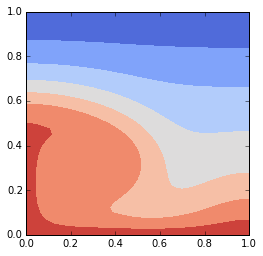

In [35]:
field = temperatureField
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
image = np.reshape(field.data[:,0], (linearMesh.elementRes[0]+1,linearMesh.elementRes[1]+1))
i = ax.imshow(np.flipud(image), interpolation='nearest', cmap='coolwarm', extent=[0., 1., 0., 1.])
ax.contourf(image, cmap='coolwarm', extent=[0., 1., 0., 1.])
#
#fig.colorbar(i) 


<matplotlib.colorbar.Colorbar instance at 0x120928200>

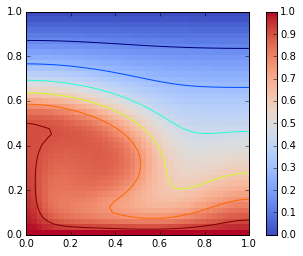

In [36]:
field = temperatureField
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
image = np.reshape(field.data[:,0], (linearMesh.elementRes[0]+1,linearMesh.elementRes[1]+1))
i = ax.imshow(np.flipud(image), interpolation='nearest', cmap='coolwarm', extent=[0., 1., 0., 1.])
ax.contour(image, extent=[0., 1., 0., 1.])
fig.colorbar(i) 
#fig.savefig('imshow_extent.png', facecolor='0.95')

In [33]:
#switch off to run in Parallel

In [34]:
# lets check FEM solution
velMag = plt.Figure()
velMag.Surface(fn.math.dot(velocityField,velocityField), linearMesh)
velMag.show()

AttributeError: 'Figure' object has no attribute 'Surface'

Figure 1. Steady state snapshots of temperature, viscosity, RMS velocity, second invariant of the stress tensor, and (right column) corresponding laterally averaged profiles for Case 1 obtained with the code Underworld. 

Figure 2.. As in Figure 1, but for Case 2... The four profiles can be found in the Data Set S2 of the supporting information.

#References

<a name="cite-tosi2015community"/><sup>[^](#ref-1) </sup>Tosi, Nicola and Stein, Claudia and Noack, Lena and H&uuml;ttig, Christian and Maierov&aacute;, Petra and Samuel, Henri and Davies, DR and Wilson, CR and Kramer, SC and Thieulot, Cedric and others. 2015. _A community benchmark for viscoplastic thermal convection in a 2-D square box_.



<!--bibtex

@article{tosi2015community,
  title={A community benchmark for viscoplastic thermal convection in a 2-D square box},
  author={Tosi, Nicola and Stein, Claudia and Noack, Lena and H{\"u}ttig, Christian and Maierov{\'a}, Petra and Samuel, Henri and Davies, DR and Wilson, CR and Kramer, SC and Thieulot, Cedric and others},
  journal={Geochemistry, Geophysics, Geosystems},
  year={2015},
  publisher={Wiley Online Library}
}

... Other Bibtex entries go here.

-->